In [1]:
import read_mta_stations as s
import read_mta_turnstile as t
import read_tech_compaines as c
import create_station_heatmap as h

In [2]:
stations = s.read_mta_stations()
stations.sample(5)

,key,name,LINE,lon,lat
439,440,135th St,A-B-C,-73.94753480879213,40.817905559212676
411,412,163rd St - Amsterdam Av,A-C,-73.93989200188344,40.83601299923096
343,344,Ave H,Q,-73.96151793942495,40.62920837758969
46,47,149th St - Grand Concourse,4,-73.9273847542618,40.81830344372315
36,37,Elmhurst Ave,E-M-R,-73.8820347465864,40.74237007972169


In [3]:
companies = c.read_tech_companies()
companies

,COMPANY,LAT,LON
0,Accenture Content Studio,40.725410,-74.004690
1,Accenture,40.763000,-73.979030
2,Thoughtworks,40.744678,-73.984901
3,Amazon,40.753050,-73.999440
4,Bank of America,40.755390,-73.984710
5,Facebook,40.730701,-73.991531
6,HP,40.744830,-73.999460
7,Microsoft,40.756989,-73.989708
8,Two Sigma,40.723270,-74.004390
9,Workday,40.748170,-73.985000


In [4]:
turnstiles = t.read_mta_turnstile()
turnstiles.sample(5)

Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180505.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180512.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180519.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180526.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180602.txt


,index,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,entries_offset,exits_offset,hourly_entries,hourly_exits
830968,61924,N116,R198,00-03-01,NOSTRAND AV,AC,IND,05/13/2018,12:00:00,REGULAR,5796345,2859149.0,2018-05-13 12:00:00,5796969,2859385.0,624,236.0
339670,23873,C025,R215,00-00-00,86 ST,R,BMT,04/30/2018,12:00:00,REGULAR,1936493,581312.0,2018-04-30 12:00:00,1936933,581480.0,440,168.0
53647,148257,R221,R170,01-06-01,14 ST-UNION SQ,456LNQRW,IRT,04/30/2018,21:00:00,REGULAR,71158265,3452565.0,2018-04-30 21:00:00,71158786,3452682.0,521,117.0
251294,153809,R242,R049,01-03-03,51 ST,6,IRT,05/16/2018,12:00:00,REGULAR,5304668,3882109.0,2018-05-16 12:00:00,5304922,3882275.0,254,166.0
10387,39554,J035,R008,00-00-00,111 ST,J,BMT,05/02/2018,08:00:00,REGULAR,3601550,5120451.0,2018-05-02 08:00:00,3601735,5120527.0,185,76.0


## Function to build a heat map

In [5]:
import seaborn as sns
import pandas as pd

# Probably turn this into a function to make it easier
agg = turnstiles.groupby(['STATION','DATE','TIME'])[['hourly_entries']].sum().reset_index()
# agg[agg.hourly_entries == 183956]
agg.DATE = pd.to_datetime(agg.DATE, format='%m/%d/%Y')
agg.TIME = pd.to_datetime(agg.TIME, format='%H:%M:%S')
agg['day_name'] = agg.DATE.dt.day_name()
agg['hour_of_day'] = agg.TIME.dt.hour

# turnstiles[turnstiles.hourly_entries > 100000].sort_values('hourly_entries')

AttributeError: module 'seaborn' has no attribute 'xlable'

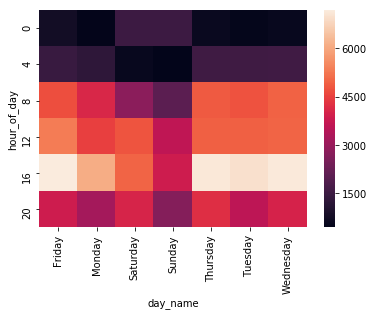

In [6]:
hm = agg.loc[agg.STATION == '1 AV',['hour_of_day','day_name','hourly_entries']]
hm = hm.groupby(['hour_of_day','day_name'])['hourly_entries'].mean().reset_index()
hm = hm.pivot(index='hour_of_day',columns='day_name',values='hourly_entries')
sns.heatmap(hm)
sns.xlable;


# Make a dataframe cross-product stations to companies

In [116]:
import numpy as np
from geopy.distance import geodesic
import pandas as pd

def merge_station_company(stations, companies):
    
    # cross join the two data frames
    stations['_tmpkey'] = 1
    companies['_tmpkey'] = 1
    station_companies = pd.merge(companies, stations, how='outer', on='_tmpkey').drop('_tmpkey', axis=1)
    
    # remove rd, th, and st to match stations with the turnstile data
    station_companies.name = station_companies.name.str.replace('rd ',' ')
    station_companies.name = station_companies.name.str.replace('th ',' ')
    station_companies.name = station_companies.name.str.replace('st ',' ')
    
    station_companies['distance'] = np.nan
    station_companies['comp_lat_lon'] = list(zip(station_companies.LAT, station_companies.LON))
    station_companies['station_lat_lon'] = list(zip(station_companies.lat, station_companies.lon))
    station_companies['distance'] = [geodesic(v, station_companies.iloc[k,10]).miles for k, v in enumerate(station_companies.comp_lat_lon)]
    

    return station_companies

In [114]:
station_companies = merge_station_company(stations, companies)

station_mean = agg.groupby(['STATION'])['hourly_entries'].mean()
station_mean.columns = ['mean_entries']
station_max = agg.groupby(['STATION'])['hourly_entries'].max().reset_index()

# set indicies to join
station_companies.index = station_companies.name.str.upper()
station_companies.rename(columns={'name':'STATION_nm'}, inplace=True)
station_companies.index.names = ['STATION']

station_mean.name = 'mean_entries'
joined = station_companies.join(station_mean, how='left', on='STATION' )
joined[joined.mean_entries.isnull()]

,COMPANY,LAT,LON,key,STATION_nm,LINE,lon,lat,distance,comp_lat_lon,station_lat_lon,mean_entries
STATION,,,,,,,,,,,,
103 ST - CORONA PLAZA,Accenture Content Studio,40.72541,-74.00469,189,103 St - Corona Plaza,7,-73.86269999830412,40.749865000555545,7.641133,"(40.72541, -74.00469)","(40.749865000555545, -73.86269999830412)",NaN
104TH-102ND STS,Accenture Content Studio,40.72541,-74.00469,14,104th-102nd Sts,J-Z,-73.84443500029684,40.69516599823373,8.669501,"(40.72541, -74.00469)","(40.69516599823373, -73.84443500029684)",NaN
116 ST - COLUMBIA UNIVERSITY,Accenture Content Studio,40.72541,-74.00469,167,116 St - Columbia University,1,-73.96410999757751,40.807722001230864,6.065657,"(40.72541, -74.00469)","(40.807722001230864, -73.96410999757751)",NaN
137 ST - CITY COLLEGE,Accenture Content Studio,40.72541,-74.00469,172,137 St - City College,1,-73.95367600087873,40.82200799968475,7.182681,"(40.72541, -74.00469)","(40.82200799968475, -73.95367600087873)",NaN
138 ST - GRAND CONCOURSE,Accenture Content Studio,40.72541,-74.00469,141,138 St - Grand Concourse,4-5,-73.92984899935611,40.81322399958908,7.220244,"(40.72541, -74.00469)","(40.81322399958908, -73.92984899935611)",NaN
149 ST - GRAND CONCOURSE,Accenture Content Studio,40.72541,-74.00469,289,149 St - Grand Concourse,2-5,-73.92672247438611,40.81833014409742,7.605237,"(40.72541, -74.00469)","(40.81833014409742, -73.92672247438611)",NaN
149 ST - GRAND CONCOURSE,Accenture Content Studio,40.72541,-74.00469,47,149 St - Grand Concourse,4,-73.9273847542618,40.81830344372315,7.585053,"(40.72541, -74.00469)","(40.81830344372315, -73.9273847542618)",NaN
15 ST - PROSPECT PARK,Accenture Content Studio,40.72541,-74.00469,107,15 St - Prospect Park,F-G,-73.97973580592873,40.66003568810021,4.697498,"(40.72541, -74.00469)","(40.66003568810021, -73.97973580592873)",NaN
161 ST - YANKEE STADIUM,Accenture Content Studio,40.72541,-74.00469,48,161 St - Yankee Stadium,4,-73.92569199505733,40.82823032742169,8.216403,"(40.72541, -74.00469)","(40.82823032742169, -73.92569199505733)",NaN


In [115]:
turnstiles.STATION.unique()

array(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST', '111 ST',
       '116 ST', '116 ST-COLUMBIA', '121 ST', '125 ST', '135 ST',
       '137 ST CITY COL', '138/GRAND CONC', '14 ST', '14 ST-UNION SQ',
       '145 ST', '149/GRAND CONC', '14TH STREET', '15 ST-PROSPECT',
       '155 ST', '157 ST', '161/YANKEE STAD', '167 ST', '168 ST',
       '169 ST', '170 ST', '174 ST', '174-175 STS', '175 ST', '176 ST',
       '18 AV', '18 ST', '181 ST', '182-183 STS', '183 ST', '190 ST',
       '191 ST', '2 AV', '20 AV', '207 ST', '21 ST', '21 ST-QNSBRIDGE',
       '215 ST', '219 ST', '225 ST', '23 ST', '231 ST', '233 ST',
       '238 ST', '25 AV', '25 ST', '28 ST', '3 AV', '3 AV 138 ST',
       '3 AV-149 ST', '33 ST', '33 ST-RAWSON ST', '34 ST-HERALD SQ',
       '34 ST-HUDSON YD', '34 ST-PENN STA', '36 ST', '39 AV', '4 AV-9 ST',
       '40 ST LOWERY ST', '42 ST-BRYANT PK', '42 ST-PORT AUTH', '45 ST',
       '46 ST', '46 ST BLISS ST', '47-50 STS ROCK', '49 ST', '4AV-9 ST',
       '5 AV/53 ST',

In [64]:
min_d = station_companies.groupby('COMPANY')['distance'].min().reset_index()
station_companies.merge(min_d, on=['distance','COMPANY'],how='inner')

,COMPANY,LAT,LON,key,name,LINE,lon,lat,distance,comp_lat_lon,station_lat_lon
0,Accenture Content Studio,40.725410,-74.004690,395,Spring St,A-C-E,-74.00373899843763,40.72622700129312,0.075302,"(40.72541, -74.00469)","(40.72622700129312, -74.00373899843763)"
1,Accenture,40.763000,-73.979030,350,57th St,F,-73.97736800085171,40.76408500081713,0.114929,"(40.763, -73.97903000000001)","(40.76408500081713, -73.97736800085171)"
2,Thoughtworks,40.744678,-73.984901,200,28th St,4-6-6 Express,-73.98426400110407,40.743069999259035,0.115883,"(40.744678, -73.98490100000001)","(40.743069999259035, -73.98426400110407)"
3,Amazon,40.753050,-73.999440,470,34th St - Hudson Yards,7-7 Express,-74.00219709442206,40.75544635961596,0.219710,"(40.75305, -73.99944)","(40.75544635961596, -74.00219709442206)"
4,Bank of America,40.755390,-73.984710,60,42nd St - Bryant Pk,B-D-F-M,-73.98459099904711,40.754184001312545,0.083451,"(40.755390000000006, -73.98470999999999)","(40.754184001312545, -73.98459099904711)"
5,Facebook,40.730701,-73.991531,1,Astor Pl,4-6-6 Express,-73.99106999861966,40.73005400028978,0.050781,"(40.730701, -73.99153100000001)","(40.73005400028978, -73.99106999861966)"
6,HP,40.744830,-73.999460,436,23rd St,A-C-E,-73.99804100117201,40.74590599939995,0.105158,"(40.74483, -73.99946)","(40.74590599939995, -73.99804100117201)"
7,Microsoft,40.756989,-73.989708,362,42nd St - Port Authority Bus Term,A-C-E,-73.98973500085859,40.757307998551504,0.022057,"(40.756989000000004, -73.989708)","(40.757307998551504, -73.98973500085859)"
8,Two Sigma,40.723270,-74.004390,90,Canal St,1-2,-74.0062770001748,40.72285399778783,0.103138,"(40.72327, -74.00439)","(40.72285399778783, -74.0062770001748)"
9,Workday,40.748170,-73.985000,366,Herald Sq - 34th St,B-D-F-M,-73.98777189072918,40.74978939990011,0.183426,"(40.74817, -73.985)","(40.74978939990011, -73.98777189072918)"


In [65]:
groups = station_companies.groupby(['COMPANY'])
top_company_station = pd.DataFrame(columns=['COMPANY','name','distance'])
for name, g in groups:
    top_company_station = top_company_station.append(g.nsmallest(5,'distance').loc[:,['COMPANY','name','distance']])

top_company_station
# station_companies[station_companies.COMPANY == 'Accenture']
# g_df.sort_values(['COMPANY','distance'])
# .sort_values()

# station_companies.describe()

,COMPANY,name,distance
584,Accenture,57th St,0.114929
611,Accenture,7th Ave,0.139985
585,Accenture,57th St,0.140079
577,Accenture,50th St,0.267638
589,Accenture,5th Ave - 53rd St,0.282439
431,Accenture Content Studio,Spring St,0.075302
228,Accenture Content Studio,Canal St,0.195057
326,Accenture Content Studio,Houston St,0.199231
233,Accenture Content Studio,Canal St - Holland Tunnel,0.317707
409,Accenture Content Studio,Prince St,0.374353


## ToDos
1. build a data frame with mean and max for each station and join to the station_companies data frame
2. calcualte statistics of d^2 + mean or d^2 + max

In [101]:
station_mean = agg.groupby(['STATION'])['hourly_entries'].mean()
station_mean.columns = ['mean_entries']
station_max = agg.groupby(['STATION'])['hourly_entries'].max().reset_index()

# set indicies to join
# station_companies.index = station_companies.name.str.upper()
station_companies.rename(columns={'name':'STATION_nm'}, inplace=True)
station_companies.index.names = ['STATION']

station_mean.name = 'mean_entries'
joined = station_companies.join(station_mean, how='left', on='STATION' )

<bound method NDFrame.head of                                                    COMPANY       LAT  \
STATION                                                                
103RD ST                          Accenture Content Studio  40.72541   
103RD ST                          Accenture Content Studio  40.72541   
103RD ST                          Accenture Content Studio  40.72541   
103RD ST - CORONA PLAZA           Accenture Content Studio  40.72541   
104TH ST                          Accenture Content Studio  40.72541   
104TH-102ND STS                   Accenture Content Studio  40.72541   
110TH ST                          Accenture Content Studio  40.72541   
111TH ST                          Accenture Content Studio  40.72541   
111TH ST                          Accenture Content Studio  40.72541   
111TH ST                          Accenture Content Studio  40.72541   
116TH ST                          Accenture Content Studio  40.72541   
116TH ST                          

In [81]:
station_companies.shape

(6622, 11)

In [92]:
# agg.STATION.unique()
station_companies.STATION_nm = station_companies.STATION_nm.str.replace('rd ',' ')
station_companies.STATION_nm = station_companies.STATION_nm.str.replace('th ',' ')
station_companies.STATION_nm = station_companies.STATION_nm.str.replace('st ',' ')
station_companies.STATION_nm.unique()

array(['103 St', '103 St - Corona Plaza', '104 St', '104th-102nd Sts',
       '110 St', '111 St', '116 St', '116 St - Columbia University',
       '121 St', '125 St', '135 St', '137 St - City College',
       '138 St - Grand Concourse', '145 St', '149 St - Grand Concourse',
       '14 St', '155 St', '157 St', '15 St - Prospect Park',
       '161 St - Yankee Stadium', '163 St - Amsterdam Av', '167 St',
       '168 St', '169 St', '170 St', '174 St', '174th-175 Sts', '175 St',
       '176 St', '181 St', '182nd-183 Sts', '183 St', '18 Ave', '18 St',
       '190 St', '191 St', '1 Ave', '207 St', '20 Ave', '215 St',
       '219 St', '21 St', '21 St - Queensbridge', '225 St', '231 St',
       '233 St', '238 St', '23 St', '25 Ave', '25 St', '28 St', '30 Ave',
       '33 St', '34 St - Hudson Yards', '34 St - Penn Station', '36 Ave',
       '36 St', '39 Ave', '3 Ave', '3 Ave - 138 St', '3 Ave - 149 St',
       '40 St', '42nd St - Bryant Pk',
       '42nd St - Port Authority Bus Term', '45 St', '